Epoch 0, Loss: 23.843605041503906
Epoch 500, Loss: 0.2731052339076996
Epoch 1000, Loss: 0.2718605101108551
Epoch 1500, Loss: 0.27075275778770447
Epoch 2000, Loss: 0.2924351990222931
Epoch 2500, Loss: 0.27109113335609436
Epoch 3000, Loss: 0.2678598165512085
Epoch 3500, Loss: 0.2833280563354492
Epoch 4000, Loss: 0.23730823397636414
Epoch 4500, Loss: 0.018233809620141983


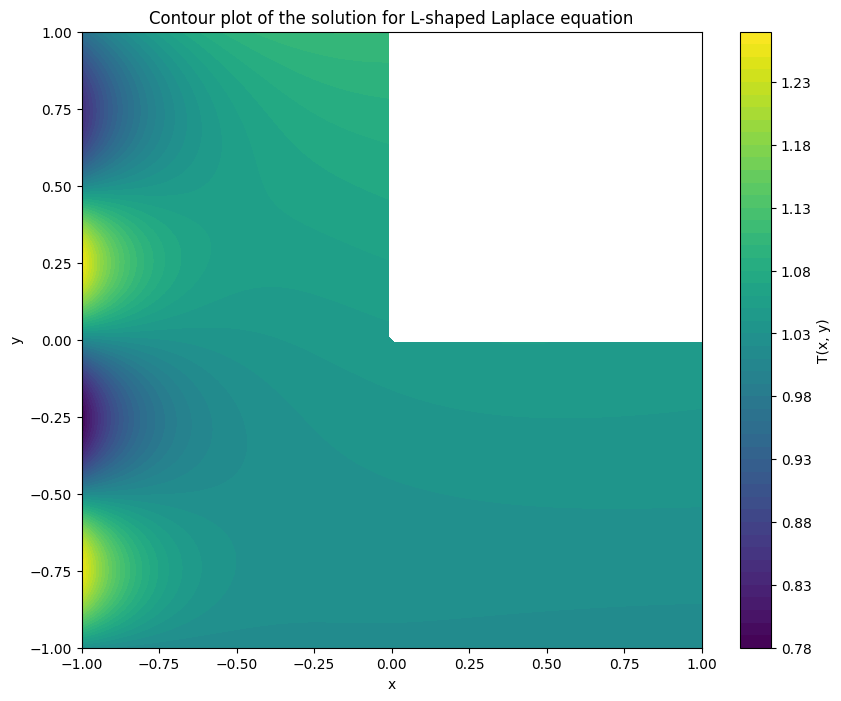

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the domain boundaries
x_min, x_max = -1.0, 1.0
y_min, y_max = -1.0, 1.0

# Generate collocation points
num_points = 10000
x = tf.random.uniform((num_points, 1), minval=x_min, maxval=x_max, dtype=tf.float32)
y = tf.random.uniform((num_points, 1), minval=y_min, maxval=y_max, dtype=tf.float32)
collocation_points = tf.concat([x, y], axis=1)

# Remove points in the upper-right quadrant to create L-shape
mask = tf.logical_or(tf.less_equal(collocation_points[:, 0], 0), tf.less_equal(collocation_points[:, 1], 0))
collocation_points = tf.boolean_mask(collocation_points, mask)

class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(100, activation='tanh') for _ in range(8)  # Increased neurons and layers
        ]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)


# Define the loss function
@tf.function
def compute_loss(model, points):
    x, y = points[:, 0:1], points[:, 1:2]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y])
        u = model(tf.concat([x, y], axis=1))
        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)
    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)
    del tape

    # PDE residual (Laplace equation)
    f = u_xx + u_yy

    # Boundary conditions
    bc1 = model(tf.concat([x, tf.ones_like(y) * y_min], axis=1)) - 1.0
    bc2 = model(tf.concat([tf.ones_like(x) * x_min, y], axis=1)) - (1.0 + 0.25 * tf.sin(2*np.pi * y))

    # Add weights to boundary losses
    loss_pde = tf.reduce_mean(tf.square(f))
    loss_bc1 = tf.reduce_mean(tf.square(bc1))
    loss_bc2 = tf.reduce_mean(tf.square(bc2))

    # Weighted loss components
    loss = loss_pde + 10 * loss_bc1 + 10 * loss_bc2  # Increase weights for boundary terms
    return loss

# Train the model
model = PINN()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

num_epochs = 5000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, collocation_points)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Generate a grid for plotting
x_plot = np.linspace(x_min, x_max, 100)
y_plot = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_plot, y_plot)
points_plot = np.stack([x_grid.flatten(), y_grid.flatten()], axis=1)

# Predict the solution
u_pred = model(points_plot).numpy().reshape(100, 100)

# Create L-shaped mask
mask = np.ones_like(u_pred)
mask[50:, 50:] = np.nan

# Apply mask to the solution
u_pred_masked = u_pred * mask

# Plot the contour
plt.figure(figsize=(10, 8))
plt.contourf(x_grid, y_grid, u_pred_masked, levels=50, cmap='viridis')
plt.colorbar(label='T(x, y)')
plt.title('Contour plot of the solution for L-shaped Laplace equation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


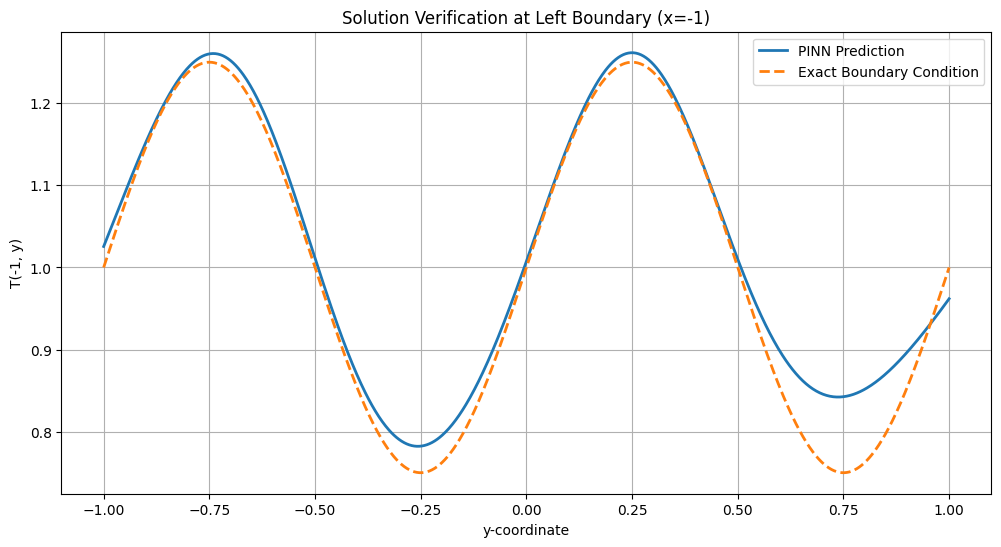

In [ ]:
# Generate points along left boundary (x=-1)
y_line = np.linspace(y_min, y_max, 1000).reshape(-1, 1)  # Increased resolution
x_line = np.ones_like(y_line) * x_min  # x = -1 for all points
points_line = np.hstack([x_line, y_line])

# Predict solution and get exact boundary condition
u_pred_line = model(points_line).numpy()
exact_solution = 1.0 + 0.25 * np.sin(2* np.pi * y_line)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(y_line, u_pred_line, label='PINN Prediction', linewidth=2)
plt.plot(y_line, exact_solution, '--', label='Exact Boundary Condition', linewidth=2)
plt.title('Solution Verification at Left Boundary (x=-1)')
plt.xlabel('y-coordinate')
plt.ylabel('T(-1, y)')
plt.legend()
plt.grid(True)
plt.show()


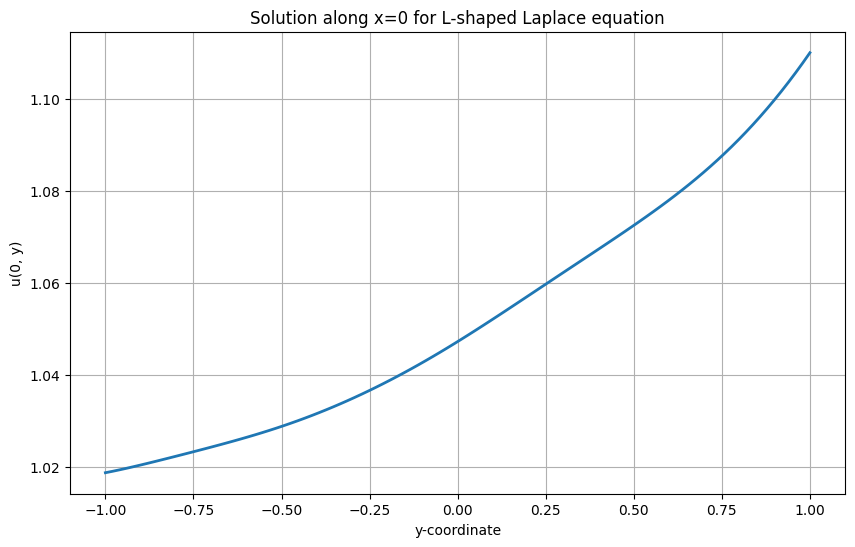

In [ ]:
# Generate points along x=0 for line plot
y_line = np.linspace(y_min, y_max, 100).reshape(-1, 1)
x_line = np.zeros_like(y_line)
points_line = np.hstack([x_line, y_line])

# Predict solution along the line
u_pred_line = model(points_line).numpy()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_line, u_pred_line, linewidth=2)
plt.title('Solution along x=0 for L-shaped Laplace equation')
plt.xlabel('y-coordinate')
plt.ylabel('u(0, y)')
plt.grid(True)
plt.show()


Epoch 0, Loss: 38.90467071533203
Epoch 500, Loss: 0.3119894564151764
Epoch 1000, Loss: 0.31126606464385986
Epoch 1500, Loss: 0.3111603558063507
Epoch 2000, Loss: 0.31109002232551575
Epoch 2500, Loss: 0.3110281229019165
Epoch 3000, Loss: 0.31102821230888367
Epoch 3500, Loss: 0.31098702549934387
Epoch 4000, Loss: 0.31094890832901
Epoch 4500, Loss: 0.3108900785446167


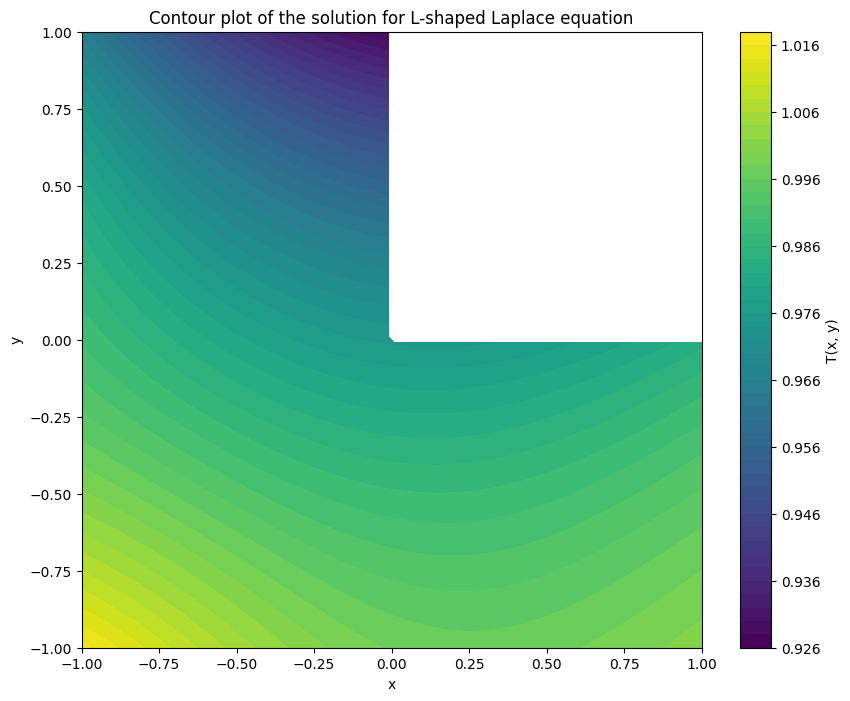

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the domain boundaries
x_min, x_max = -1.0, 1.0
y_min, y_max = -1.0, 1.0

# Generate collocation points
num_points = 10000
x = tf.random.uniform((num_points, 1), minval=x_min, maxval=x_max, dtype=tf.float32)
y = tf.random.uniform((num_points, 1), minval=y_min, maxval=y_max, dtype=tf.float32)
collocation_points = tf.concat([x, y], axis=1)

# Remove points in the upper-right quadrant to create L-shape
mask = tf.logical_or(tf.less_equal(collocation_points[:, 0], 0), tf.less_equal(collocation_points[:, 1], 0))
collocation_points = tf.boolean_mask(collocation_points, mask)

class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(64, activation='tanh') for _ in range(8)  # Increased neurons and layers
        ]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)


# Define the loss function
@tf.function
def compute_loss(model, points):
    x, y = points[:, 0:1], points[:, 1:2]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y])
        u = model(tf.concat([x, y], axis=1))
        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)
    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)
    del tape

    # PDE residual (Laplace equation)
    f = u_xx + u_yy

    # Boundary conditions
    bc1 = model(tf.concat([x, tf.ones_like(y) * y_min], axis=1)) - 1.0
    bc2 = model(tf.concat([tf.ones_like(x) * x_min, y], axis=1)) - (1.0 + 0.25 * tf.sin(128*np.pi * y))

    # Add weights to boundary losses
    loss_pde = tf.reduce_mean(tf.square(f))
    loss_bc1 = tf.reduce_mean(tf.square(bc1))
    loss_bc2 = tf.reduce_mean(tf.square(bc2))

    # Weighted loss components
    loss = loss_pde + 10 * loss_bc1 + 10 * loss_bc2  # Increase weights for boundary terms
    return loss

# Train the model
model = PINN()
# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

num_epochs = 5000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, collocation_points)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Generate a grid for plotting
x_plot = np.linspace(x_min, x_max, 100)
y_plot = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_plot, y_plot)
points_plot = np.stack([x_grid.flatten(), y_grid.flatten()], axis=1)

# Predict the solution
u_pred = model(points_plot).numpy().reshape(100, 100)

# Create L-shaped mask
mask = np.ones_like(u_pred)
mask[50:, 50:] = np.nan

# Apply mask to the solution
u_pred_masked = u_pred * mask

# Plot the contour
plt.figure(figsize=(10, 8))
plt.contourf(x_grid, y_grid, u_pred_masked, levels=50, cmap='viridis')
plt.colorbar(label='T(x, y)')
plt.title('Contour plot of the solution for L-shaped Laplace equation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


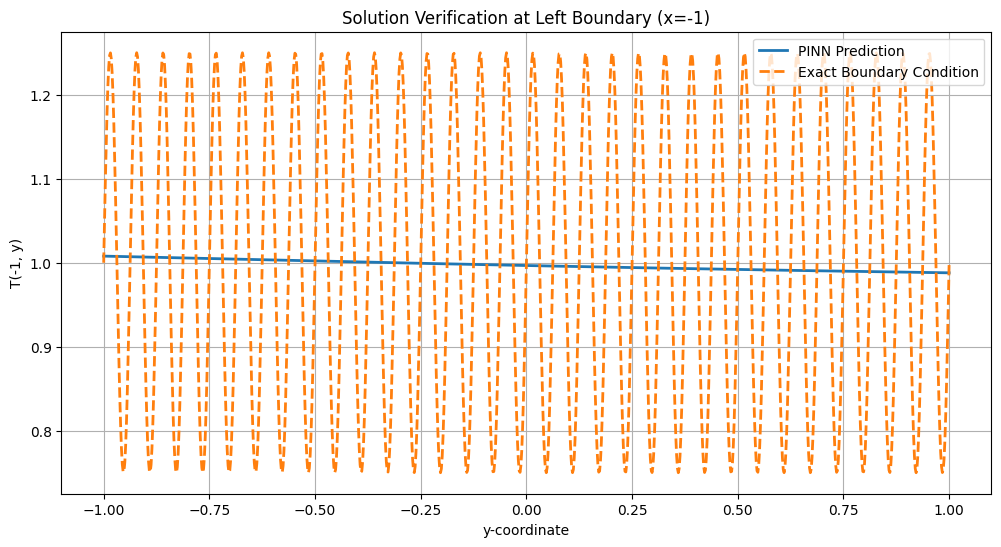

In [ ]:
# Generate points along left boundary (x=-1)
y_line = np.linspace(y_min, y_max, 1000).reshape(-1, 1)  # Increased resolution
x_line = np.ones_like(y_line) * x_min  # x = -1 for all points
points_line = np.hstack([x_line, y_line])

# Predict solution and get exact boundary condition
u_pred_line = model(points_line).numpy()
exact_solution = 1.0 + 0.25 * np.sin(32* np.pi * y_line)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(y_line, u_pred_line, label='PINN Prediction', linewidth=2)
plt.plot(y_line, exact_solution, '--', label='Exact Boundary Condition', linewidth=2)
plt.title('Solution Verification at Left Boundary (x=-1)')
plt.xlabel('y-coordinate')
plt.ylabel('T(-1, y)')
plt.legend()
plt.grid(True)
plt.show()
